# **Introduction**

**About Dataset**
---

* **Automatic categorization and segmentation** of **forest** cover is essential for **sustainable development** and **urban planning**.
* **Forests** provide **vital ecosystem services** such as **carbon storage**, **water flow**, **biodiversity**, and **recreation**.
* **Forest areas** need to be identified before **commencing any industrial activity** that **requires on-field work**.
* **Satellite or remote sensed images** can be used to **detect and segment forest** cover regions in an image.
* **Forest area segmentation** is a **binary segmentation task** that aims to **detect forest areas by assigning a binary label** (e.g., 1 for forest and 0 for non-forest) to each pixel in the image.

**Data Structure**
---

The **image dataset** contains **forest images**, which may be captured from **satellites or other sensors**. The **mask dataset** consists of **human-annotated images** that indicate whether **each pixel** in the **corresponding image** belongs to the **forest or not**. Since **forest area segmentation** is a **binary classification task**, the **mask images** are **black and white**, with **white regions** representing the **forest** and **black regions** representing **non-forest areas**.

The dataset used for **forest area segmentation** contains a total of **5108 image-mask pairs**. In addition to the **image and mask data**, the **dataset** also includes a **CSV file** that represents the **image file name with respect to its mask file name**. This file can be used to **load the data efficiently** and match the **images with their respective masks during training and evaluation**.

The availability of such a dataset allows us to **train and evaluate machine learning models** for **accurate forest area segmentation**. Various **machine learning algorithms**, such as **deep learning-based models**, can be used to perform the **segmentation task and achieve state-of-the-art results**.

# **SetUp**
---

The **first step** in any **machine learning project** is to **load the necessary modules** and set the **hyperparameters and constants** that will be used throughout the notebook. In this section, we will **load the modules** required for **data loading, data preprocessing, and model building**. We will also define some **hyperparameters and constants** that will be used throughout the notebook.

For **data loading and preprocessing**, we will be using the `numpy`, `pandas`, and `matplotlib` libraries. These libraries provide **essential functions** for **loading, manipulating, and visualizing data**. We will also be using the `tensorflow` library for **building and training our segmentation model**.

Next, we will define some **hyperparameters and constants** that will be used throughout the notebook. The hyperparameters include the **batch size, learning rate, and number of epochs.** These hyperparameters will affect the **performance of the model during training.** We will also define some constants such as **image size, number of classes, and paths to the data directory**. These constants will be used during **data loading and preprocessing**.

Overall, loading the **necessary modules** and setting the **hyperparameters and constants** is an **important step** in **preparing the notebook** for **data loading, preprocessing, and model building**. It allows us to keep our code **organized and reduces the chances of errors** occurring during the implementation.

In [ ]:
!pip install tf-explain

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# importing the zipfile module
from zipfile import ZipFile

# loading the temp.zip and creating a zip object
with ZipFile("/content/drive/MyDrive/Saumya/archive.zip", 'r') as zObject:

    # Extracting all the members of the zip
    # into a specific location.
    zObject.extractall(
        path="/content/dataset")

In [ ]:
# Common
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from IPython.display import clear_output as cls

# Data
from tqdm import tqdm
import tensorflow.data as tfd

# Data Visualization
import matplotlib.pyplot as plt

# Model Building
from tensorflow.keras import layers
from tensorflow.keras import callbacks
from tensorflow.keras import optimizers
from tensorflow.keras import metrics
from tensorflow.keras.optimizers.schedules import ExponentialDecay

# Model visualization
from tensorflow.keras.utils import plot_model
from tf_explain.core.grad_cam import GradCAM

# Extra
from typing import List, Tuple, Union

**Hyperparameters and constants**
---

In [ ]:
# Image and Mask Dimensions
IMAGE_HEIGHT = 160
IMAGE_WIDTH = 160
N_IMAGE_CHANNELS = 3
N_MASK_CHANNELS = 1

# Image and Mask Size
IMAGE_SIZE = (IMAGE_WIDTH, IMAGE_HEIGHT, N_IMAGE_CHANNELS)
MASK_SIZE = (IMAGE_WIDTH, IMAGE_HEIGHT, N_MASK_CHANNELS)

# Batch Size and Learning Rate
BATCH_SIZE = 32
BASE_LR = 1e-2

# Model Name
MODEL_NAME = 'UNetForestSegmentation'

# Model Training
EPOCHS = 100

# Data Paths
ROOT_IMAGE_DIR = r'/content/dataset/Forest Segmented/Forest Segmented/images'
ROOT_MASK_DIR = r'/content/dataset/Forest Segmented/Forest Segmented/masks'
METADATA_CSV_PATH = r'/content/dataset/Forest Segmented/Forest Segmented/meta_data.csv'

# Model Architecture
FILTERS = 32

Let's set up a **random seed**, setting up a **random seed** is essential in a **machine learning project** for the following reasons:

* **Reproducibility**: Setting up a random seed ensures that the results obtained from the model are reproducible. When a random seed is set, the same random numbers are generated each time the model is run. This means that the same results can be obtained every time the code is executed, which is critical for debugging, testing, and reproducing results.

* **Consistency**: Setting up a random seed ensures that the same set of samples are selected for training and testing the model every time it is run. This consistency in the data selection process allows us to compare the performance of different models with the same data.

* **Fairness**: In some cases, the random initialization of model parameters can lead to different results due to variations in the random seed. This can be particularly important in fairness-sensitive applications, such as when the model is used to make decisions that impact people's lives. By setting a random seed, we can reduce the impact of random variation on the model's performance and ensure that the model is fair to all groups.

In [ ]:
# Random Seed
SEED = 42

np.random.seed(SEED)
tf.random.set_seed(SEED)

The **number** **42** is **commonly used** as a **random seed** in the **machine learning community** for **historical and cultural reasons**. In the book ***The Hitchhiker's Guide to the Galaxy*** by *Douglas Adams*, the number **42** is famously referred to as the ***Answer to the Ultimate Question of Life, the Universe, and Everything.*** This has led to the **number 42** being adopted as a **sort of inside joke** or **cultural reference** in the **programming community**.

# **Utility Functions**

Now we can shift our focus to **loading the forest area segmentation data into memory**. For this purpose, we will be creating **2 utility functions** that will load the data for us. These functions will help us to **load the forest images and their respective masks** and create a **TensorFlow data set** that we can use for **training our model**.

* The **first function**, the `load_image_and_mask`, will be responsible for **loading the forest image** and its **respective mask** given the **image and the mask file paths**. This function will also apply the **required preprocessing operations on the image**, such as **resizing and normalization**, to ensure that the data is in the **correct format for training our model**.

* The **second function**, the `load_dataset`, will be responsible for **loading all the forest images and their respective masks present in the data set** and converting that data into our **TensorFlow data set**. This function will utilize the `load_image_and_mask` to load **each individual image** and its **respective mask**, preprocess the data, and **organize it into batches** that can be fed into the model during training.

By creating these **helper functions**, we can **easily load and preprocess the data** required for our **forest area segmentation project**. This will **streamline the process of loading and processing the data**.

In [ ]:
def load_image_and_mask(image_path: str, mask_path: str) -> Tuple[tf.Tensor, tf.Tensor]:

    '''
    This function takes the file paths of an image and its corresponding mask as input. It first reads the images, then decodes them into tensors,
    and resizes them to a standard size. After that, the image and mask tensors are normalized by clipping the pixel values between 0 and 1.
    Finally, the function converts the image and mask tensors to the float32 data type and returns them as a tuple.

    Arguments :
        image_path : The path to the image to be loaded.
        mask_path  : The path to the mask to be loaded.

    Returns :
        image : This is the loaded and the processed image.
        mask  : This is the loaded and the processed mask.

    '''

    # Read the images
    image = tf.io.read_file(filename = image_path)
    mask  = tf.io.read_file(filename = mask_path)

    # Decode the images
    image = tf.image.decode_jpeg(contents = image, channels = N_IMAGE_CHANNELS)
    mask  = tf.image.decode_jpeg(contents = mask,  channels = N_MASK_CHANNELS)

    # Convert the image to a Tensor
    image = tf.image.convert_image_dtype(image = image, dtype = tf.float32)
    mask  = tf.image.convert_image_dtype(image = mask, dtype = tf.float32)

    # Resize the image to the desired dimensions
    image = tf.image.resize(images = image, size = (IMAGE_WIDTH, IMAGE_HEIGHT))
    mask  = tf.image.resize(images = mask, size = (IMAGE_WIDTH, IMAGE_HEIGHT))

    # Normalize the image
    image = tf.clip_by_value(image, clip_value_min = 0.0, clip_value_max = 1.0)
    mask  = tf.clip_by_value(mask, clip_value_min = 0.0, clip_value_max = 1.0)

    # Final conversion
    image = tf.cast(image, dtype = tf.float32)
    mask  = tf.cast(mask,  dtype = tf.float32)

    return image, mask

Before proceeding with the **data loading process**, we need to **review the metadata file** which contains the **image filenames and their corresponding mask filenames**. This will allow us to **streamline the data loading function and simplify the data loading process**.

In [ ]:
# Load CSV File
metadata = pd.read_csv(METADATA_CSV_PATH)

# Quick look
metadata.head()

image                mask
0   10452_sat_08.jpg   10452_mask_08.jpg
1   10452_sat_18.jpg   10452_mask_18.jpg
2  111335_sat_00.jpg  111335_mask_00.jpg
3  111335_sat_01.jpg  111335_mask_01.jpg
4  111335_sat_02.jpg  111335_mask_02.jpg

Before moving ahead, it is important to note that although the **metadata contains the file names of the images and masks**, we need their **complete file paths to load the data**. Therefore, we will add **the root path** of the **images and masks** to this data frame.

In [ ]:
# Add root path to image file names
metadata['image'] = [os.path.join(ROOT_IMAGE_DIR,filename) for filename in metadata['image']]

# Add mask path to image file names
metadata['mask']  = [os.path.join(ROOT_MASK_DIR,filename) for filename in metadata['mask']]

In [ ]:
# Quick Check
metadata.head()

image  \
0  /content/dataset/Forest Segmented/Forest Segme...   
1  /content/dataset/Forest Segmented/Forest Segme...   
2  /content/dataset/Forest Segmented/Forest Segme...   
3  /content/dataset/Forest Segmented/Forest Segme...   
4  /content/dataset/Forest Segmented/Forest Segme...   

                                                mask  
0  /content/dataset/Forest Segmented/Forest Segme...  
1  /content/dataset/Forest Segmented/Forest Segme...  
2  /content/dataset/Forest Segmented/Forest Segme...  
3  /content/dataset/Forest Segmented/Forest Segme...  
4  /content/dataset/Forest Segmented/Forest Segme...

In [ ]:
def load_dataset(
    image_paths: list, mask_paths: list, split_ratio: float=0.2,
    batch_size: int=BATCH_SIZE, shuffle: bool=True,
    buffer_size: int=1000, n_repeat: int=1
) -> Union[Tuple[tfd.Dataset, tfd.Dataset], tfd.Dataset]:
    '''
    This function loads the image and mask data from the provided file paths and creates a TensorFlow dataset. The function
    first creates space to store the image and mask data in numpy arrays. It then iterates over each image and mask pair,
    loading them using the load_image_and_mask function and storing them in the numpy arrays.

    The function then creates a TensorFlow dataset using the numpy arrays. If shuffle is True, it shuffles the dataset
    with a buffer size of buffer_size. If split_ratio is not None, it splits the dataset into two parts with sizes determined
    by the split_ratio, and converts them into batches of size batch_size with drop_remainder=True. The two resulting datasets
    are returned as a tuple.

    If split_ratio is None, the entire dataset is converted into batches of size batch_size with drop_remainder=True,
    and the resulting dataset is returned.

    Args:
        image_paths: A list of strings, containing the file paths of the input images.

        mask_paths: A list of strings, containing the file paths of the corresponding mask images.

        split_ratio: A float value between 0 and 1, representing the ratio of data to be used for validation.
                    If split_ratio is set to None, then no data will be split for validation.

        batch_size: An integer, representing the batch size for the input data.

        shuffle: A boolean value indicating whether the data should be shuffled or not.

        buffer_size: An integer, representing the buffer size for shuffling the data.

        n_repeat: An integer, representing the total number of repetations of the data.

    Returns:
        If split_ratio is not None, then the function returns a tuple of two Tensorflow datasets.
        The first dataset contains the training data and the second dataset contains the validation data.

        If split_ratio is None, then the function returns a single Tensorflow dataset containing the
        input data batched and pre-fetched for training.

    '''

    # Create space for storing the data.
    images = np.empty(shape=(len(image_paths), *IMAGE_SIZE), dtype=np.float32)
    masks  = np.empty(shape=(len(mask_paths), *MASK_SIZE),  dtype=np.float32)

    # Iterate over the data.
    index = 0
    for image_path, mask_path in tqdm(zip(image_paths, mask_paths), desc='Loading'):

        # Load the image and the mask.
        image, mask = load_image_and_mask(image_path = image_path, mask_path = mask_path)

        # Store the image and the mask.
        images[index] = image
        masks[index]  = mask

        # Increment the index.
        index += 1

    # Create a Tensorflow data.
    data_set = tfd.Dataset.from_tensor_slices((images, masks)).repeat(n_repeat)

    # Shuffle the data set.
    if shuffle:
        data_set = data_set.shuffle(buffer_size)

    # Split the data
    if split_ratio is not None:

        # Calculate new data sizes after splitting.
        keep_ratio = 1-split_ratio
        data_1_len = int((keep_ratio) * len(images))
        data_2_len = int(split_ratio * len(images))

        # Divide the data into 2 parts.
        data_1 = data_set.take(data_1_len)
        data_2 = data_set.skip(data_1_len).take(data_2_len)

        # Convert data into batches.
        data_1 = data_1.batch(batch_size, drop_remainder=True).prefetch(tfd.AUTOTUNE)
        data_2 = data_2.batch(batch_size, drop_remainder=True).prefetch(tfd.AUTOTUNE)

        # Return the data
        return data_1, data_2

    else:

        # Convert data into batches
        data_set = data_set.batch(batch_size, drop_remainder=True).prefetch(tfd.AUTOTUNE)

        # Return the data
        return data_set

Out data loading function is ready. It's time to use it and **load the data set**.

In [ ]:
# Training and Testing Data
full_train_ds, test_ds = load_dataset(
    image_paths = metadata['image'],
    mask_paths = metadata['mask'],
    split_ratio = 0.1,
    shuffle = True,
    n_repeat=3,
)

Loading: 5108it [00:36, 139.64it/s]


Let's have a look at the **data distribution**.

In [ ]:
print("*"*100)
print(f"{' '*30}Training Data Size : {full_train_ds.cardinality().numpy() * BATCH_SIZE}")
print(f"{' '*30}Testing Data Size  : {test_ds.cardinality().numpy() * BATCH_SIZE}")
print("*"*100)

****************************************************************************************************
                              Training Data Size : 4576
                              Testing Data Size  : 480
****************************************************************************************************


Currently, we have a **dataset with only training and testing data**. To be able to **evaluate our model's performance** during **training**, we need to **split our training data** into **training and validation data**. This can be achieved using the **tf.data.Dataset API's** *take and skip* methods, which will help us **split the dataset** into **two parts**. We will use a **90:10 split**, i.e., **90% of the data for training and 10% for validation**.

In [ ]:
# Training Data size
full_train_size = full_train_ds.cardinality().numpy()

# Split Ratio
train_val_split = 0.1
valid_size = int(full_train_size * train_val_split)
train_size = full_train_size - valid_size

# Split Data
train_ds = full_train_ds.take(train_size)
valid_ds = full_train_ds.skip(train_size).take(valid_size)

In [ ]:
print("*"*100)
print(f"{' '*30}Training Data Size   : {train_ds.cardinality().numpy() * BATCH_SIZE}")
print(f"{' '*30}Validation Data Size : {valid_ds.cardinality().numpy() * BATCH_SIZE}")
print(f"{' '*30}Testing Data Size    : {test_ds.cardinality().numpy() * BATCH_SIZE}")
print("*"*100)

****************************************************************************************************
                              Training Data Size   : 4128
                              Validation Data Size : 448
                              Testing Data Size    : 480
****************************************************************************************************


# **Data Visualization**

We have **successfully loaded our training, validation, and testing data**, which is an **essential step** before starting the **model building process**. It's always good to have a **look at the dataset** before starting to **understand the data better and come up with a better solution**. However, to plot this type of data, we need to **plot the images and their respective masks together**. To achieve this, we can create a **utility function** called *show_images_and_masks* that will plot both the images and masks side by side for visualization purposes.

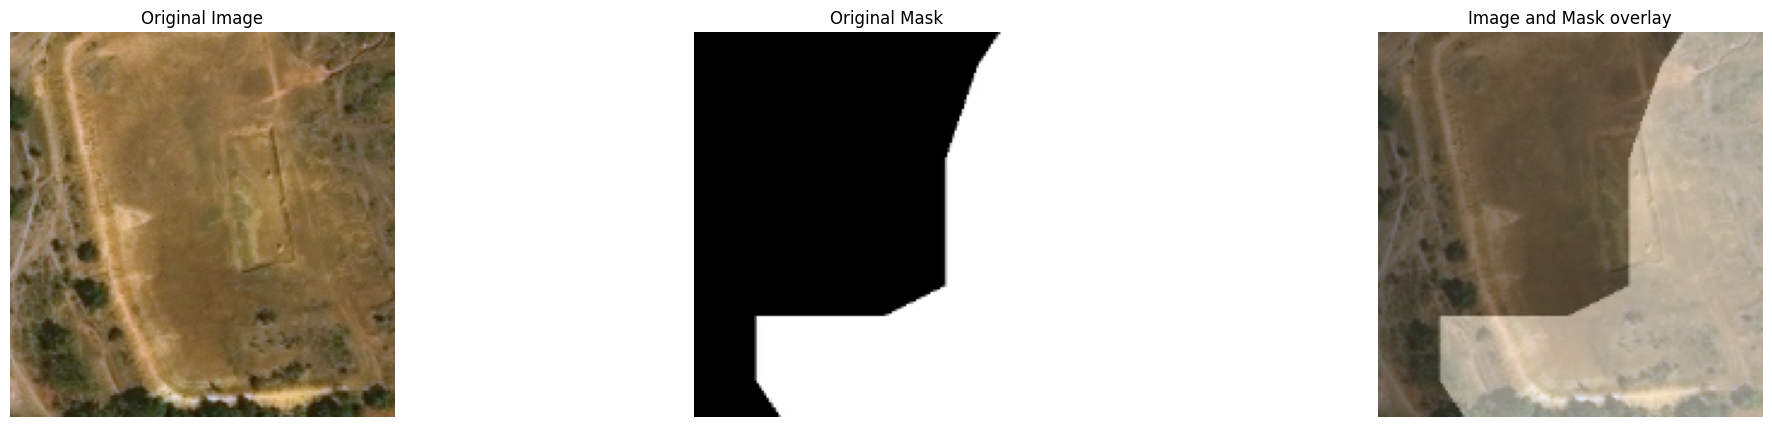

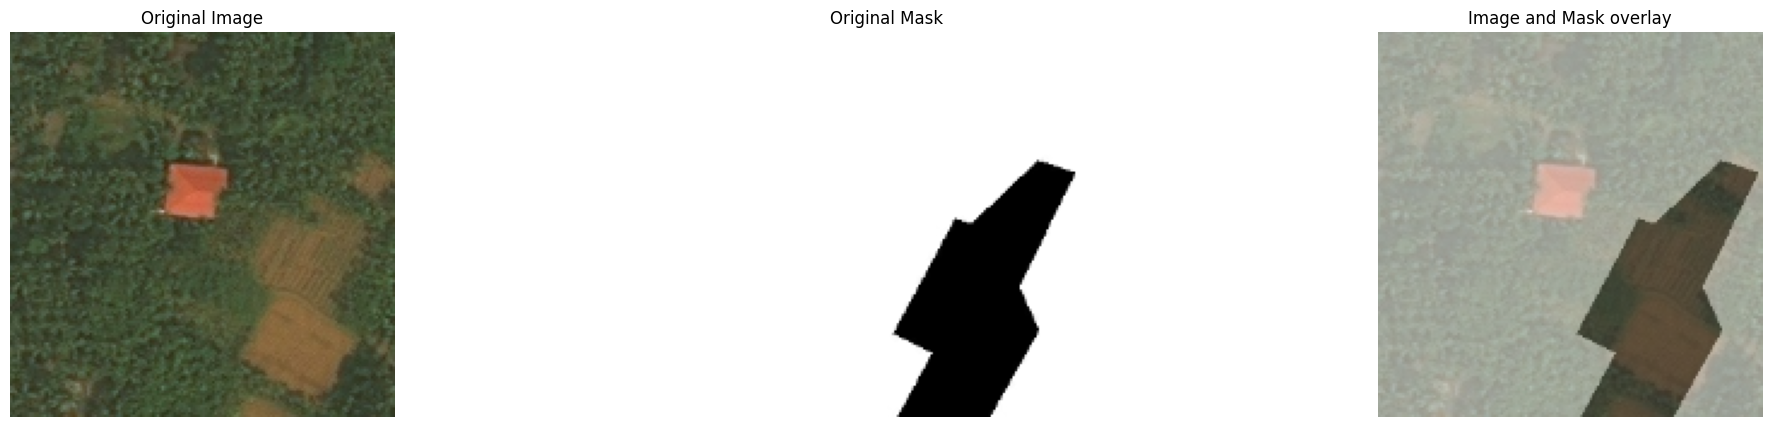

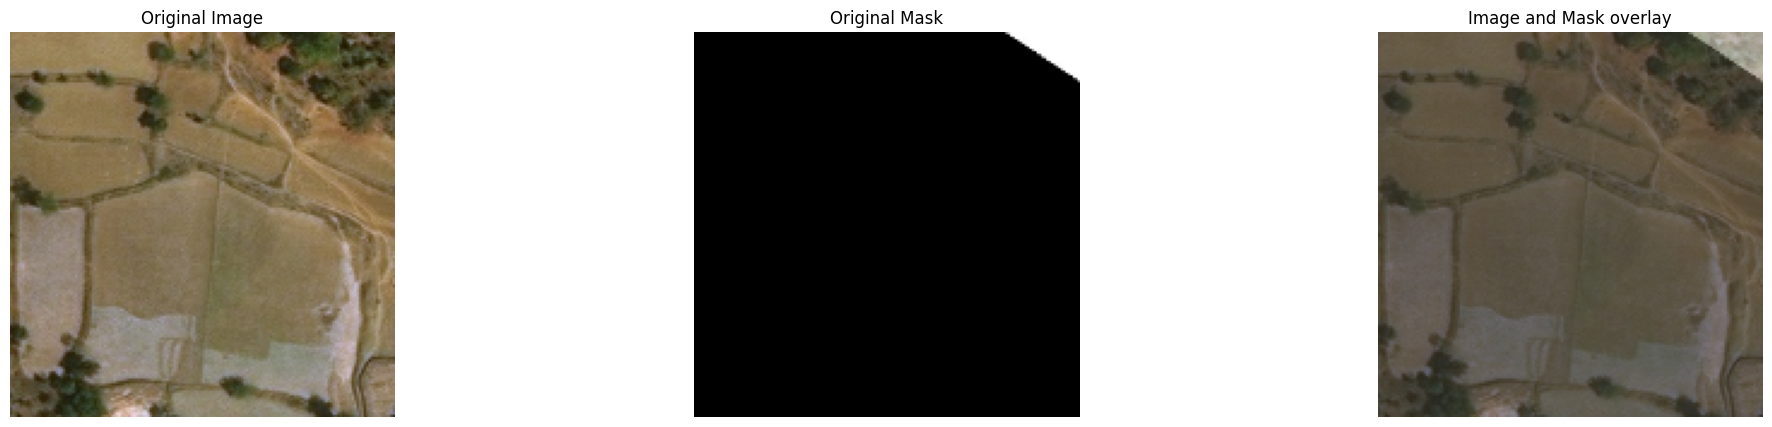

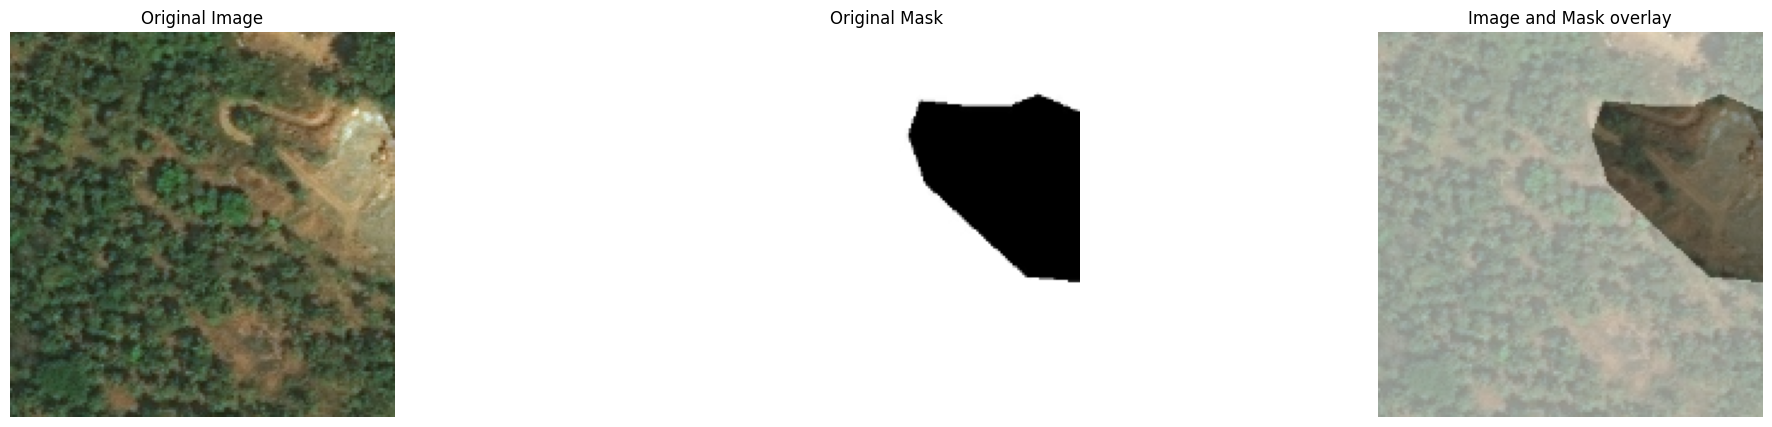

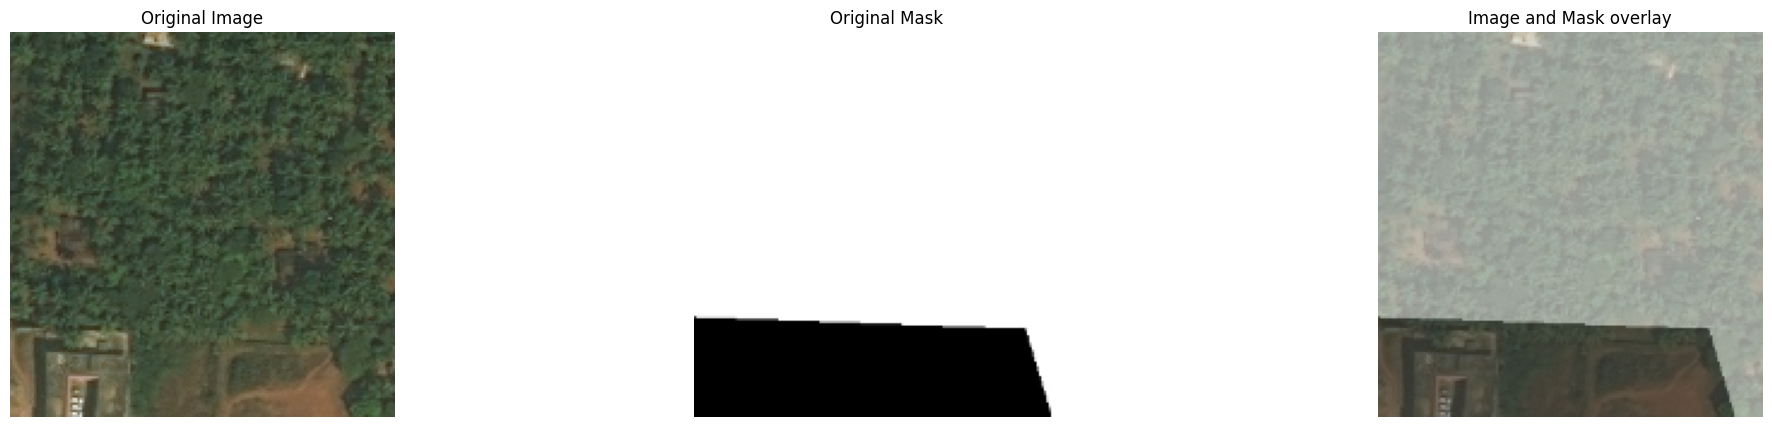

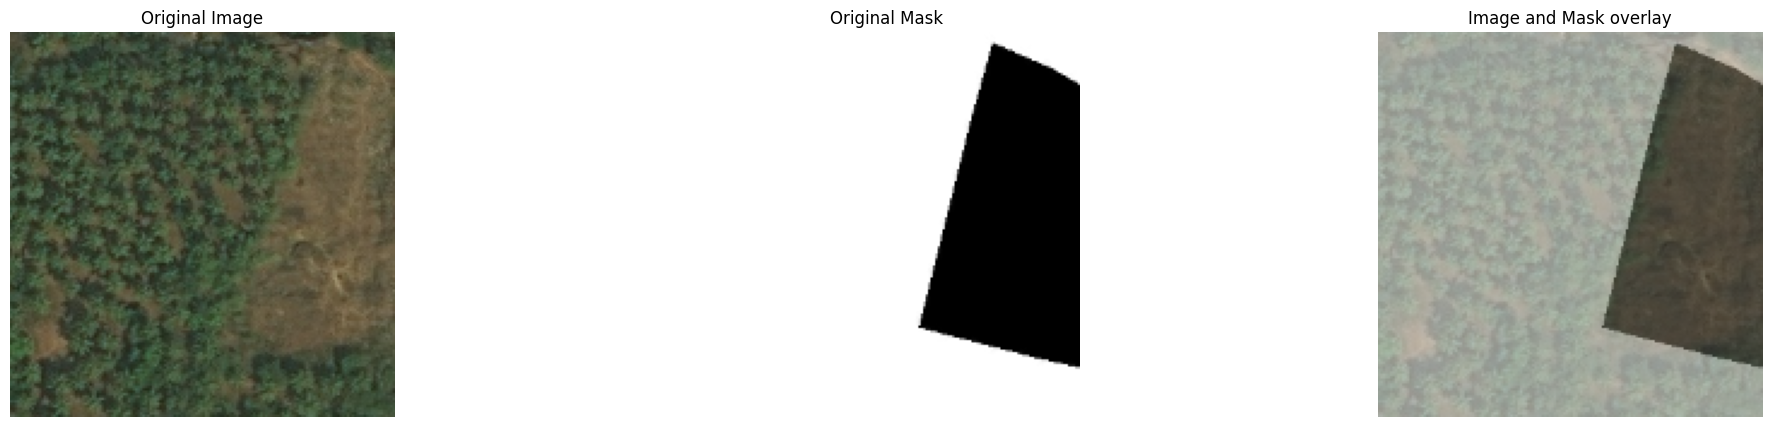

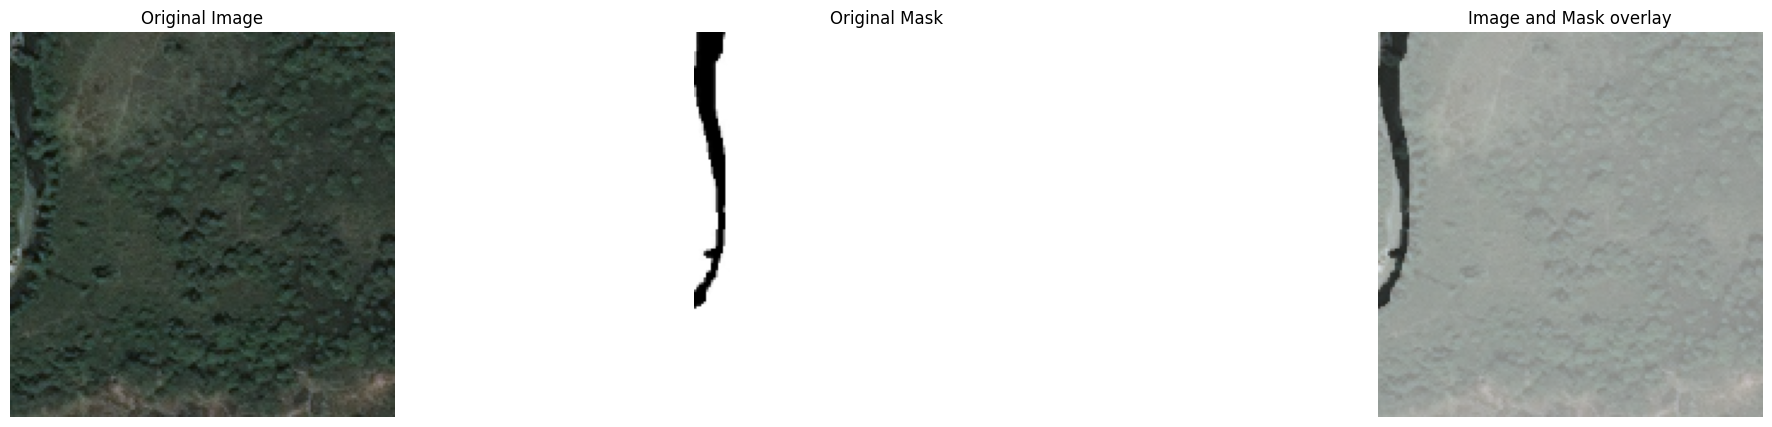

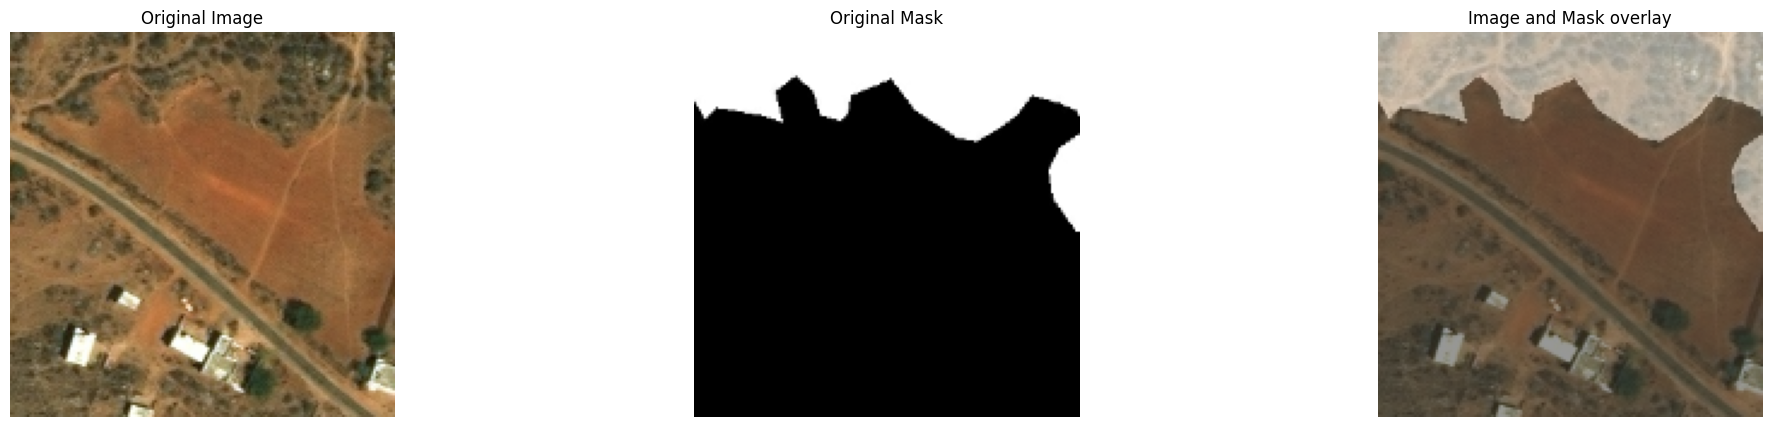

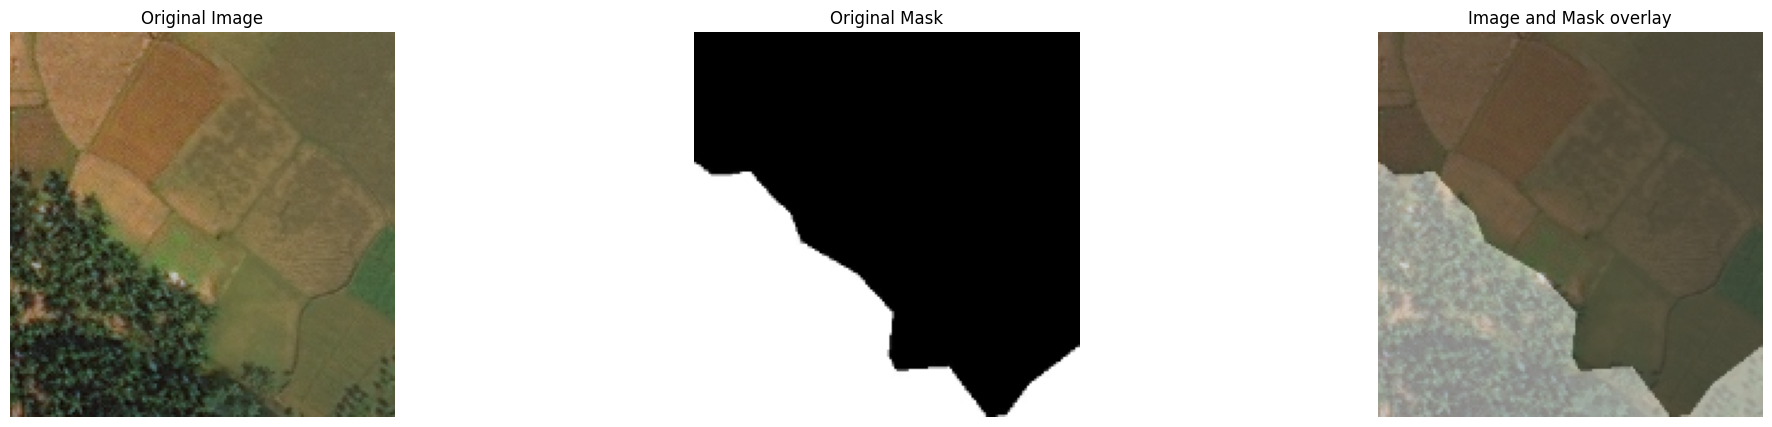

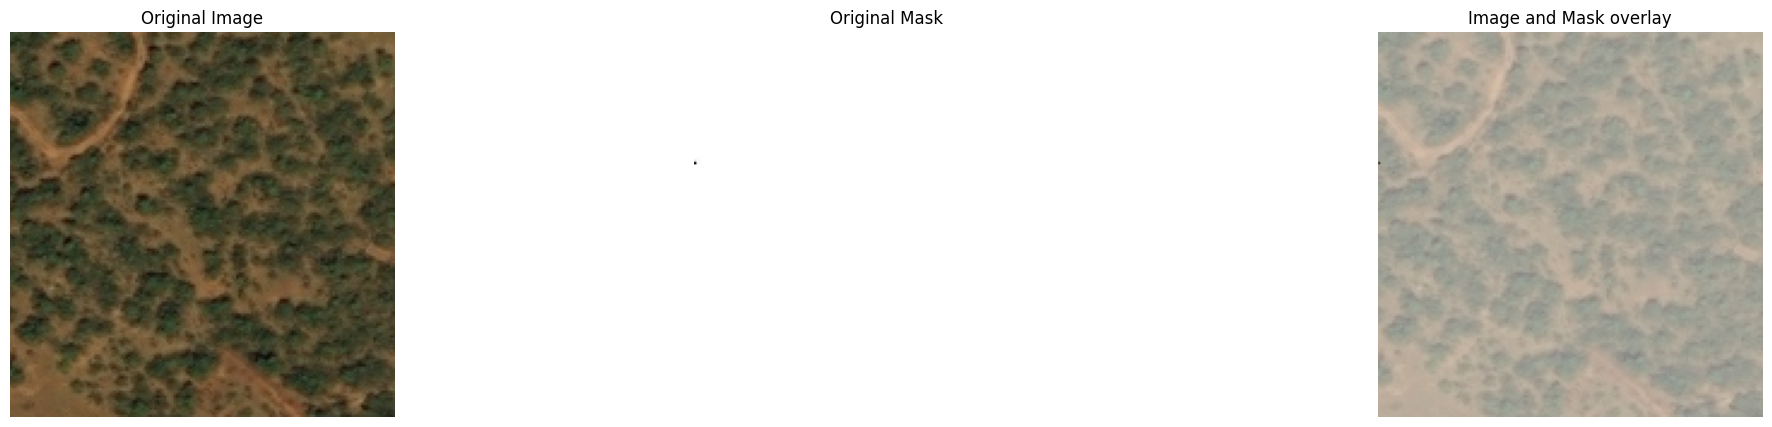

In [ ]:
def show_images_and_masks(data : tfd.Dataset, n_images: int=10, FIGSIZE: tuple=(25, 5), model: tf.keras.Model=None):

    # Configuration
    if model is None:
        n_cols = 3
    else:
        n_cols = 5

    # Collect the data
    images, masks = next(iter(data))

    # Iterate over the data
    for n in range(n_images):

        # Plotting configuration
        plt.figure(figsize=FIGSIZE)

        # Plot the image
        plt.subplot(1, n_cols, 1)
        plt.title("Original Image")
        plt.imshow(images[n])
        plt.axis('off')

        # Plot the Mask
        plt.subplot(1, n_cols, 2)
        plt.title("Original Mask")
        plt.imshow(masks[n], cmap='gray')
        plt.axis('off')

        # Plot image and mask overlay
        plt.subplot(1, n_cols, 3)
        plt.title('Image and Mask overlay')
        plt.imshow(masks[n], alpha=0.8, cmap='binary_r')
        plt.imshow(images[n], alpha=0.5)
        plt.axis('off')

        # Model predictions
        if model is not None:
            pred_mask = model.predict(tf.expand_dims(images[n], axis=0))[0]
            pred_mask = pred_mask>=0.5
            plt.subplot(1, n_cols, 4)
            plt.title('Predicted Mask')
            plt.imshow(pred_mask, cmap='gray')
            plt.axis('off')

            plt.subplot(1, n_cols, 5)
            plt.title('Predicted Mask Overlay')
            plt.imshow(pred_mask, alpha=0.8, cmap='binary_r')
            plt.imshow(images[n], alpha=0.5)
            plt.axis('off')

        # Show final plot
        plt.show()

show_images_and_masks(data=train_ds)

After taking a look at the **training data images**, their **respective masks** and their **overlay**, it seems that the **segmentation masks** have **not been accurately produced**. This will likely impact the **model's performance**, as it is being **trained on faulty data**. However, since this is a **binary semantic segmentation task**, the **UNET architecture** is typically regarded as the **best approach**. Using this **architecture** should help to **improve the accuracy** of the **segmentation masks** and therefore lead to **better model performance**.

# **UNet : An Encoder-Decoder Network**

The **UNet architecture** is a **widely used convolutional neural network (CNN) model** for **image segmentation tasks**. It was proposed by **Olaf Ronneberger, Philipp Fischer, and Thomas Brox in 2015**, and it has since become a **popular architecture** for many **image segmentation tasks**, especially in the **medical imaging domain**.

The **UNet architecture** consists of a **contracting path**, where the **spatial resolution** of the **input image** is reduced by a **series of convolutional and pooling layers**, and an **expansive path**, where the **spatial resolution** is **increased by a series of convolutional and upsampling layers**, we refer to these as **Encoder & Decoder**, respectively.. The **two paths** are then **merged together** using **skip connections**, which allow the model to use **high-resolution features** from the **contracting path** with **low-resolution features from the expansive path**.

![image.png](attachment:82a90699-561b-479d-b165-20921100c3fc.png)

The **contracting path** is composed of a **series of convolutional layers**, each followed by a **rectified linear unit (ReLU)** activation function and a **2x2 max pooling layer**, which reduces the **spatial resolution** of the **feature maps by half**. This process is **repeated multiple times**, resulting in a **sequence of feature maps** with progressively **smaller spatial resolutions** and **larger receptive fields**.

The **expansive path** is composed of a **series of upsampling layers**, each followed by a **convolutional layer**, a **ReLU activation function**, and a **2x2 convolutional layer**. The **upsampling layers double the spatial resolution** of the **feature maps**, while the **convolutional layers decrease** the **number of channels**, allowing the **model to learn spatially precise segmentation maps**.

The **skip connections**, which connect corresponding layers from **the contracting and expansive paths**, allow the model to use **high-resolution features** from the **contracting path** with **low-resolution features** from the **expansive path**. These **skip connections** help to **localize the segmentation maps** and **improve the segmentation accuracy**.

![image.png](attachment:57083350-ba4e-4c43-a221-5088b27764da.png)

Finally, the output of the **UNet architecture** is a **segmentation map** with the **same spatial resolution** as the **input image**, where each pixel is assigned a **probability** value between **0 and 1**, indicating the **likelihood of belonging to the foreground object**.


## **Unet - Encoder Block**
---

As you study the **encoder part** of the **UNet architecture**, you may notice that there are **repetitive convolution operations** applied. Therefore, it would be **more efficient** to **encapsulate** these operations into a **layer,** resulting in **more concise and efficient coding**.

In [ ]:
class EncoderBlock(layers.Layer):

    def __init__(self, filters: int, max_pool: bool=True, rate=0.2, **kwargs) -> None:
        super().__init__(**kwargs)

        # Params
        self.rate = rate
        self.filters = filters
        self.max_pool = max_pool

        # Layers : Initialize the model layers that will be later called
        self.max_pooling = layers.MaxPool2D(pool_size=(2,2), strides=(2,2))
        self.conv1 = layers.Conv2D(
            filters=filters,
            kernel_size=3,
            strides=1,
            padding='same',
            activation='relu',
            kernel_initializer='he_normal'
        )
        self.conv2 = layers.Conv2D(
            filters=filters,
            kernel_size=3,
            strides=1,
            padding='same',
            activation='relu',
            kernel_initializer='he_normal'
        )
        self.drop = layers.Dropout(rate)
        self.bn = layers.BatchNormalization()

    def call(self, X, **kwargs):

        X = self.bn(X)
        X = self.conv1(X)
        X = self.drop(X)
        X = self.conv2(X)

        # Apply Max Pooling if required
        if self.max_pool:
            y = self.max_pooling(X)
            return y, X
        else:
            return X

    def get_config(self):
        config = super().get_config()
        config.update({
            'filters': self.filters,
            'max_pool': self.max_pool,
            'rate': self.rate
        })

    def __repr__(self):
        return f"{self.__class__.name}(F={self.filters}, Pooling={self.max_pool})"

## **UNet - Decoder Block**

---

As we have created an **efficient encoder block** for our **UNet architecture**, we now need to create a **decoder block** that will help us to **decode the encoded feature maps** back into the **original image size**. Similar to the **encoder block**, the **decoder block** should also have a **similar structure** with the **inverse set of layers to the encoder**. This will allow us to **combine the encoded feature maps** with the **corresponding feature maps** from the **decoder**.

In [ ]:
class DecoderBlock(layers.Layer):

    def __init__(self, filters: int, rate: float = 0.2, **kwargs):
        super().__init__(**kwargs)

        self.filters = filters
        self.rate = rate

        # Initialize the model layers
        self.convT = layers.Conv2DTranspose(
            filters = filters,
            kernel_size = 3,
            strides = 2,
            padding = 'same',
            activation = 'relu',
            kernel_initializer = 'he_normal'
        )
        self.bn = layers.BatchNormalization()
        self.net = EncoderBlock(filters = filters, rate = rate, max_pool = False)

    def call(self, inputs, **kwargs):

        # Get both the inputs
        X, skip_X = inputs

        # Up-sample the skip connection
        X = self.bn(X)
        X = self.convT(X)

        # Concatenate both inputs
        X = layers.Concatenate(axis=-1)([X, skip_X])
        X = self.net(X)

        return X

    def get_config(self):
        config = super().get_config()
        config.update({
            'filters': self.filters,
            'rate': self.rate,
        })
        return config

    def __repr__(self):
        return f"{self.__class__.__name__}(F={self.filters}, rate={self.rate})"


## **UNet - Encoder Decoder Net**
---
Now that we have implemented the **encoder block and decoder block**, we can combine them to form the **encoder-decoder network** that makes up the **U-Net architecture**. The **encoder and decoder networks** are connected by **skip connections** that allow information to **flow directly from the encoder to the decoder**, improving the **segmentation performance**. The **skip connections** are created by **concatenating** the **output of the encoder block** with the corresponding **feature map from the decoder block**. The resulting **U-Net** architecture is a **fully convolutional neural network** that can be **trained end-to-end for various image segmentation tasks**.

In [ ]:
# Input Layer
input_layer = layers.Input(shape=(IMAGE_SIZE), name="InputLayer")

# The encoder network
pool1, encoder1 = EncoderBlock(FILTERS,   max_pool=True, rate=0.1, name="EncoderLayer1")(input_layer)
pool2, encoder2 = EncoderBlock(FILTERS*2, max_pool=True, rate=0.1, name="EncoderLayer2")(pool1)
pool3, encoder3 = EncoderBlock(FILTERS*4, max_pool=True, rate=0.2, name="EncoderLayer3")(pool2)
pool4, encoder4 = EncoderBlock(FILTERS*8, max_pool=True, rate=0.2, name="EncoderLayer4")(pool3)

# The encoder encoding
encoding = EncoderBlock(FILTERS*16, max_pool=False, rate=0.3, name="EncodingSpace")(pool4)

# The decoder network
decoder4 = DecoderBlock(FILTERS*8, rate=0.2, name="DecoderLayer1")([encoding, encoder4])
decoder3 = DecoderBlock(FILTERS*4, rate=0.2, name="DecoderLayer2")([decoder4, encoder3])
decoder2 = DecoderBlock(FILTERS*2, rate=0.1, name="DecoderLayer3")([decoder3, encoder2])
decoder1 = DecoderBlock(FILTERS,  rate=0.1, name="DecoderLayer4")([decoder2, encoder1])

# Final output layer.
final_conv = layers.Conv2D(
    filters = 1,
    kernel_size = 1,
    strides=1,
    padding='same',
    activation='sigmoid',
    name="OutputMap"
)(decoder1)

# Unet Model
unet_model = keras.Model(
    inputs = input_layer,
    outputs = final_conv,
    name = "UNetModel"
)

In [ ]:
# Model Summary
unet_model.summary()

Model: "UNetModel"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 InputLayer (InputLayer)     [(None, 160, 160, 3)]        0         []                            
                                                                                                  
 EncoderLayer1 (EncoderBloc  ((None, 80, 80, 32),         10156     ['InputLayer[0][0]']          
 k)                           (None, 160, 160, 32))                                               
                                                                                                  
 EncoderLayer2 (EncoderBloc  ((None, 40, 40, 64),         55552     ['EncoderLayer1[0][0]']       
 k)                           (None, 80, 80, 64))                                                 
                                                                                          

## **UNet - Model Visualization**
---

Let's take a **closer look** at the **model architecture** through **visual aids**.

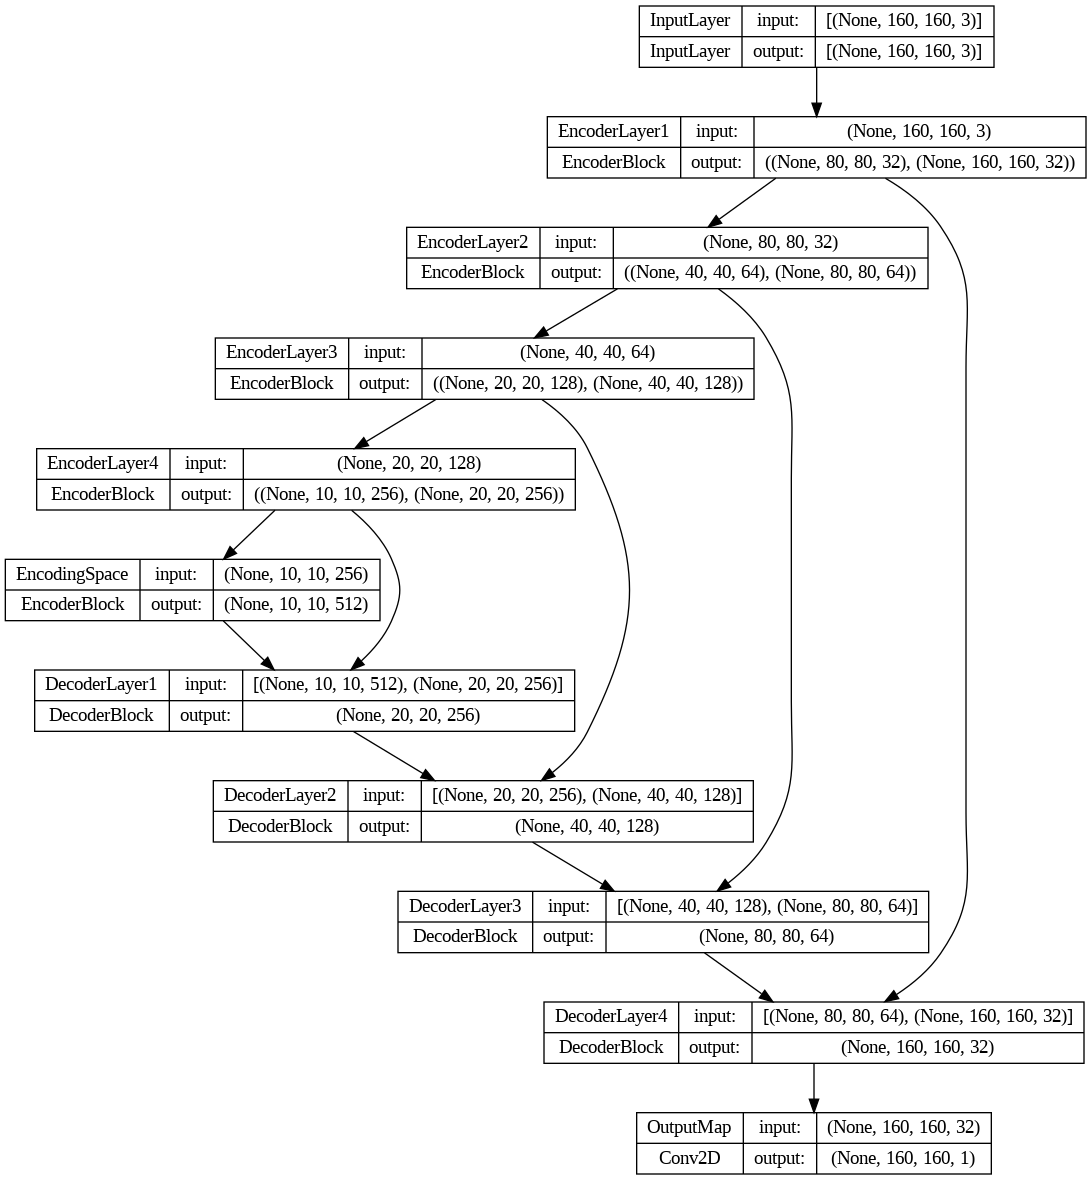

In [ ]:
tf.keras.utils.plot_model(model = unet_model, to_file = "UnetModel.png", dpi = 96, show_shapes=True,)

Now you can see why it's called a **Unet**, as the architecture resembles the **letter 'U'.** However, it's worth noting that some people **may perceive** it more as a **'V', including myself**.

## **UNet - Model Training**
---
As we prepare to **commence training**, I'd like to take a **moment to introduce** an **important concept** that will be useful in understanding the **model's performance**: **GradCAM, or Gradient-weighted Class Activation Mapping**.

**GradCAM** is a technique that **visualizes which regions** of the **input image** the model is **attending to when making predictions**. This **visualization** is achieved by generating a **heatmap** that **highlights the regions of the image** that are **most important** for the **model's prediction**. The technique uses the **gradients** of the **predicted class** with **respect to the feature maps** of the **last convolutional layer** of the **model to generate the heatmap**.

By **utilizing GradCAM**, we can **gain insight** into **how the model is interpreting** the **input data** and **why it's making specific predictions**. This technique is **particularly useful** for **models with many layers** and is **commonly used in computer vision applications**.

In [ ]:
class ShowProgress(callbacks.Callback):
    """A callback that displays the original image, the original mask,
    the predicted mask, and the Grad-CAM visualization for a sample image
    after each epoch of training.

    Args:
        data (tf.data.Dataset): A dataset of image-mask pairs.
        layer_name (str): The name of the layer to use for Grad-CAM.
        cmap (str, optional): The colormap to use for displaying the masks.
            Defaults to 'gray'.
        output_dir (str, optional): The directory to save the output images.
            If None, the images will not be saved. Defaults to None.
        num_images (int, optional): The number of images to display.
            Defaults to 1.
        file_format (str, optional): The format to save the output images in.
            Defaults to 'png'.
    """
    def __init__(self, data: tf.data.Dataset, layer_name: str, cmap: str = 'gray',
                 output_dir: str = None, num_images: int = 1, file_format: str = 'png',
                 **kwargs):
        super().__init__(**kwargs)

        # Validate inputs
        if not isinstance(data, tf.data.Dataset):
            raise ValueError('The `data` parameter must be a tf.data.Dataset.')
        if not isinstance(layer_name, str):
            raise ValueError('The `layer_name` parameter must be a string.')
        if not isinstance(num_images, int) or num_images < 1:
            raise ValueError('The `num_images` parameter must be an integer greater than 0.')
        if file_format not in ['png', 'jpg', 'pdf']:
            raise ValueError('The `file_format` parameter must be "png", "jpg", or "pdf".')

        self.data = data
        self.layer_name = layer_name
        self.cmap = cmap
        self.output_dir = output_dir
        self.num_images = num_images
        self.file_format = file_format

    def on_epoch_end(self, epoch, logs=None):
        """Displays the original image, the original mask, the predicted mask,
        and the Grad-CAM visualization for a sample image.
        """
        # Plotting configuration
        plt.figure(figsize=(25, 8 * self.num_images))

        for i in range(self.num_images):
            # Get Data
            images, masks = next(iter(self.data))
            images = images.numpy()
            masks = masks.numpy()

            # Select image
            index = np.random.randint(len(images))
            image, mask = images[index], masks[index]

            # Make Prediction
            pred_mask = self.model.predict(np.expand_dims(image, axis=0))[0]

            # Initialize Grad CAM
            cam = GradCAM().explain(
                class_index=0,
                model=self.model,
                validation_data=(np.expand_dims(image, axis=0), mask),
                layer_name=self.layer_name
            )

            # Show Image
            plt.subplot(1, 4, 1)
            plt.title("Original Image")
            plt.imshow(image)
            plt.axis('off')

            # Show Mask
            plt.subplot(1, 4, 2)
            plt.title("Original Mask")
            plt.imshow(mask, cmap=self.cmap)
            plt.axis('off')

            # Show Model Pred
            plt.subplot(1, 4, 3)
            plt.title("Predicted Mask")
            plt.imshow(pred_mask, cmap=self.cmap)
            plt.axis('off')

            # Show Grad CAM
            plt.subplot(1, 4, 4)
            plt.title("Grad CAM")
            plt.imshow(cam)
            plt.axis('off')

            # Save figure
            if self.output_dir is not None:
                path = os.path.join(os.curdir, self.output_dir)
                plt.savefig(f'Epoch({epoch+1})-Viz.{self.file_format}')

            # Show Final plot
            plt.show()

This **custom callback** is called `ShowProgress` and it is used for **visualizing the progress of a neural network** during **training**. It is designed to work with a **tf.data.Dataset** object and takes in **several parameters**, including the **layer name** to be **visualized** and the **colormap to be used**.

During **each epoch**, it **randomly selects an image** and its corresponding **mask** from the **dataset**, **makes a prediction** on the **image** using the **model being trained**, and then **generates a Grad CAM visualization** for the **selected layer**. It then displays the **original image**, **original mask**, **predicted mask**, and **Grad CAM visualization** in a **single plot using matplotlib**.

This callback can be useful for **gaining insights** into how a **neural network is performing during training**, by providing a **visual representation** of the **model's predictions** and how they relate to the **original images and masks**. It can also be helpful for **identifying potential issues** with the **model's performance**, such as **overfitting or underfitting**, as well as for **identifying which parts of the input image are most relevant for the model's predictions**.

In [ ]:
# Obtain data for GradCAM.
test_images, test_masks = next(iter(test_ds))

# Adding GradCAM to call backs

CALLBACKS = [
    callbacks.EarlyStopping(
        patience = 10,
        restore_best_weights = True),
#     callbacks.ModelCheckpoint(
#         MODEL_NAME + '.h5',
#         save_best_only = True),
    ShowProgress(
        data = valid_ds,
        layer_name = "DecoderLayer4"
    )
]

Before moving ahead let's define **some metrics** which will be used to **evaluate the model's performance**. Such as :

* The **Dice coefficient** (also known as the **Sørensen–Dice coefficient**) is a measure of the **similarity between two samples**. In the context of **image segmentation**, it is used to **evaluate the performance of a segmentation algorithm** by measuring the **overlap between the predicted segmentation and the ground truth segmentation.**

The **Dice coefficient** is calculated as follows:

> **dice_coeff = 2 * |X ∩ Y| / (|X| + |Y|)**

where **X and Y** are sets representing the **pixels** in the **predicted segmentation and ground truth segmentation**, respectively. **|X| and |Y|** are the **cardinalities of these sets**, and **|X ∩ Y| is the cardinality of the intersection of the sets**.

In [ ]:
def dice_coeff(y_true: tf.Tensor, y_pred: tf.Tensor, smooth: float=1.0) -> tf.Tensor:

    """Compute the Dice coefficient between predicted and true masks.

    Args:
        y_true (tf.Tensor): True masks. Shape (batch_size, height, width, num_channels).
        y_pred (tf.Tensor): Predicted masks. Shape (batch_size, height, width, num_channels).
        smooth (float): Smoothing factor to avoid division by zero.

    Returns:
        tf.Tensor: Dice coefficient score.

    """
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    intersection = tf.reduce_sum(y_true * y_pred, axis=[1, 2, 3])
    union = tf.reduce_sum(y_true, axis=[1, 2, 3]) + tf.reduce_sum(y_pred, axis=[1, 2, 3])
    dice = tf.reduce_mean((2.0 * intersection + smooth) / (union + smooth), axis=0)

    return tf.cast(dice, tf.float32)


* **Pixel accuracy** is a metric that **measures the proportion of correctly classified pixels** in an image. It is calculated as the **ratio of the total number** of **correctly classified pixels** to the **total number of pixels in the image**. This **metric is simple and straightforward** to understand but can be **misleading** in cases where the **number of pixels belonging** to **one class heavily outweighs the other class**.

* **Mean Intersection Over Union (mIoU)** is a **popular metric** for **evaluating segmentation models**. It computes the **average intersection over union (IoU) of each class**. **IoU** is the **ratio** of the **intersection of the predicted and ground truth mask to their union**. A **high mIoU** value means that the **model can accurately capture the segmentation boundary** between the **foreground and background**, and the **boundaries of different objects in the image**.

**mIoU** can be defined as:

> **mIoU = (1/n) * ∑(i=1 to n) (IoU_i)**

where **n** is the **number of classes**, and **IoU_i is the IoU for the i-th class**. Since **mIoU** considers the **average intersection over union** for **all classes**, it is a **better metric** than **pixel accuracy** for **imbalanced datasets**, where some **classes have significantly fewer pixels than others**.

In [ ]:
# Pixel Accuracy
pixel_acc = metrics.Accuracy(name="PixelAccuracy")

# Mean Intersection Over Union
mean_iou = metrics.MeanIoU(num_classes=2, name="MeanIoU")

# Exponential learning rate decay
initial_learning_rate = BASE_LR
decay_steps = 500
decay_rate = 0.96

lr_schedule = ExponentialDecay(
    initial_learning_rate,
    decay_steps,
    decay_rate,
    staircase=True
)

optimizer = optimizers.Adam(learning_rate=lr_schedule)

# Compile Model
unet_model.compile(
    loss = 'binary_crossentropy',
    optimizer = optimizer,
    metrics = [
        pixel_acc,
        mean_iou,
        dice_coeff
    ]
)

In [ ]:
# Model Training
unet_model_history = unet_model.fit(
    train_ds,
    validation_data = valid_ds,
    epochs = EPOCHS,
    callbacks = CALLBACKS,
    batch_size = BATCH_SIZE,
)

I would like to remind you that there is an **inconsistency in labeling** the images in this dataset. Specifically, the **forests**, or the **trees within image**, are **not always labeled correctly**, as can be seen in the **training images**. As a result, the **performance of model trained on this dataset can be affected**. At times, the **model's output may not match the labeled output**. However, in many cases, the **model's output is much better than the labeled output** because the model is **learning to produce a mask on all connected or clustered trees**, whereas the **human labels are not always accurate**.

This **inconsistency in labeling** can easily be **spotted during the training process**, and it's clear that the **model's predictions are often superior to the actual labels**. Therefore, it's **important to keep in mind that the model is learning from imperfect labels** and that its **output should be evaluated based on its ability to capture the underlying patterns in the data** rather than being **judged against the imperfect human labels.**

By having a look at the **GradCAM visualization**, we can clearly see that the **model has effectively learned** to **map the input images to their respective masks**. And then many cases, these **produced masks are better than their actual labels**.

I have nothing to say on the **performance of the model. It's clearly in front of you**.

## **Model Learning Curve**
----

In [ ]:
# Model History
history = unet_model_history.history

In [ ]:
plt.figure(figsize=(25,10))

plt.subplot(2,2,1)
plt.plot(history['loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Binary Croscentropy Loss')
plt.legend()
plt.grid()

plt.subplot(2,2,2)
plt.plot(history['PixelAccuracy'], label='Pixel Accuracy')
plt.plot(history['val_PixelAccuracy'], label='Validation Pixel Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Pixel Accuracy')
plt.legend()
plt.grid()

plt.subplot(2,2,3)
plt.plot(history['MeanIoU'], label='MeanIoU')
plt.plot(history['val_MeanIoU'], label='Validation MeanIoU')
plt.xlabel('Epochs')
plt.ylabel('MeanIoU Score')
plt.legend()
plt.grid()

plt.subplot(2,2,4)
plt.plot(history['dice_coeff'], label='Dice Coeff')
plt.plot(history['val_dice_coeff'], label='Validation Dice Coeff')
plt.xlabel('Epochs')
plt.ylabel('Dice Coeff Score')
plt.legend()
plt.grid()
plt.show()

When it comes to problems like **semantic segmentation, object detection, instance segmentation**, etc, I believe more on the **visual analysis of predictions**, rather than looking at these matrices. So there are no comments on these matrices from my point of view. Feel free to develop your standard point of view by looking at this learning curve.

## **Model Predictions**
---

In [ ]:
show_images_and_masks(data=train_ds, model=unet_model)

In [ ]:
show_images_and_masks(data=valid_ds, model=unet_model)

In [ ]:
show_images_and_masks(data=test_ds, model=unet_model)

* To be honest, I found the **predicted mask** to be **much more accurate** than the **labeled mask**. This is because the **predicted mask** is **focusing on labeling only the forest areas**. On the other hand, the **true labels** contain **several images** where **non-forest areas** are **also marked** as **forest areas**. However, it is up to you to decide what is correct.

* One reason for this could be **"clear boundary"**. If you look from a **human perspective**, there is **no clear boundary** between **forest and nonforest areas**. And this **could have led to the inconsistent labeling**.

* Although the **model is not perfect**, there are **many cases** in which we can see that the **model outputs a blank map**. Whenever the **image is filled with forest**. This is a **potential issue**. Because when the image is completely **filled with forest**, output** map should be completely white, but it's completely blank**.

---
Always remember that **improving data** is a **better option than improving the model**. Because if the **data quality** is  **good,** then the **model will automatically be good**. And in **this data set**, **I believe that improving the label consistency will automatically improve the model's performance**.


---
**DeepNets**

In [ ]:
unet_model.save('/content/model.h5')